In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt

In [ ]:
!ls resources/grn_benchmark/evaluation_data/300BCG_bulk

300BCG_bulk.h5ad    norman_bulk.h5ad	       xaira_HCT116_bulk.h5ad
adamson_bulk.h5ad   op_bulk.h5ad	       xaira_HEK293T_bulk.h5ad
ibd_bulk.h5ad	    parsebioscience_bulk.h5ad
nakatake_bulk.h5ad  replogle_bulk.h5ad


In [13]:
ad.read_h5ad('resources/grn_benchmark/evaluation_data/300BCG_bulk.h5ad', backed='r').obs.groupby(['cell_type', 'time', 'perturbation']).size()

/vol/tmp/users/jnourisa/ipykernel_1351033/2821488750.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ad.read_h5ad('resources/grn_benchmark/evaluation_data/300BCG_bulk.h5ad', backed='r').obs.groupby(['cell_type', 'time', 'perturbation']).size()


cell_type  time  perturbation
B          T3m   LPS             36
                 RPMI            38
CD4+ T     T3m   LPS             37
                 RPMI            38
CD8+ T     T3m   LPS             36
                 RPMI            37
Monocytes  T3m   LPS             38
                 RPMI            37
NK         T3m   LPS             37
                 RPMI            37
dtype: int64

In [3]:
df = pd.read_csv("output/vc/vc_scores.csv")

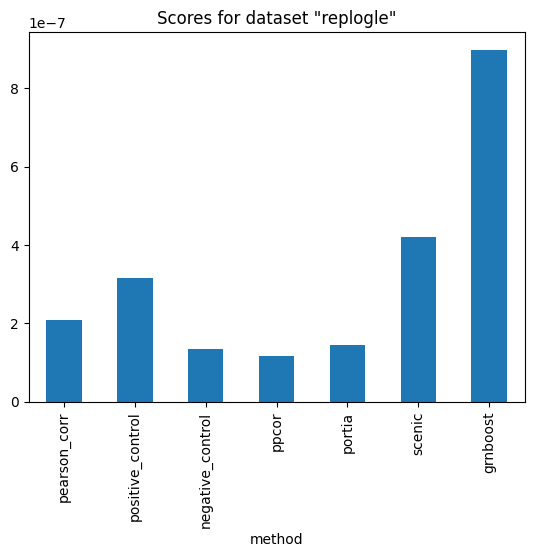

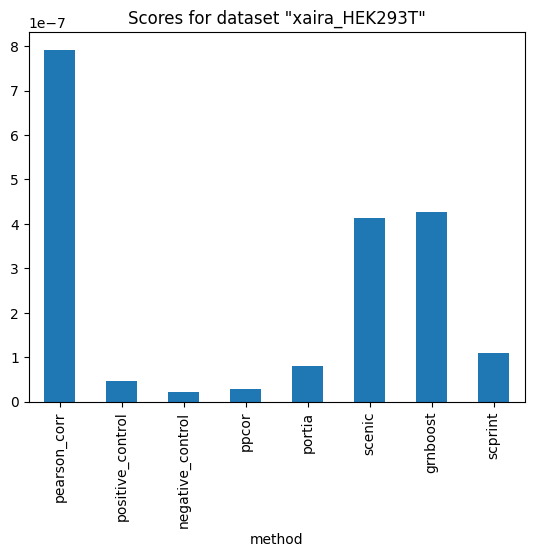

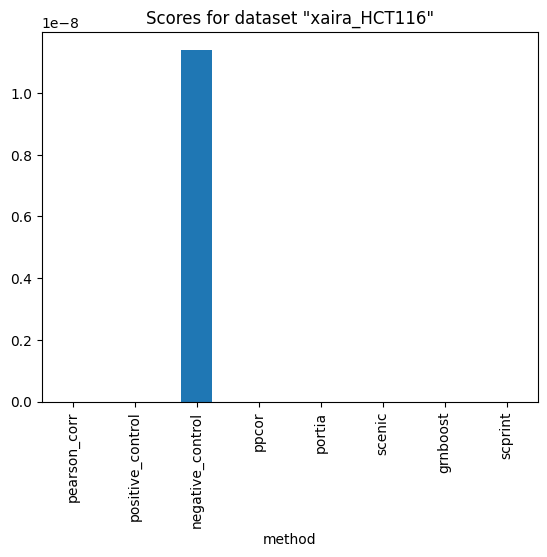

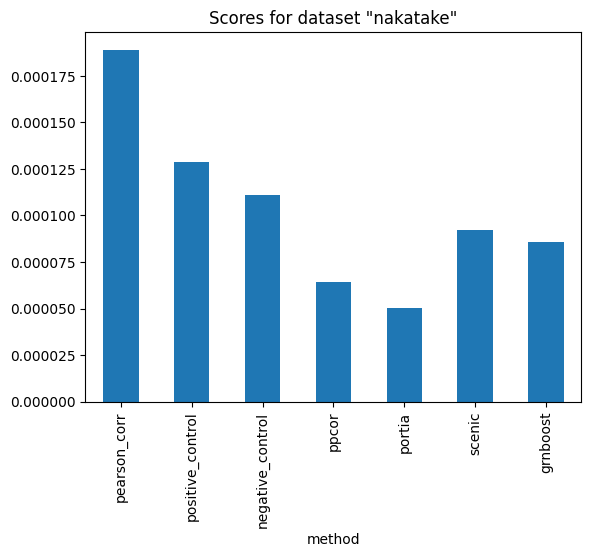

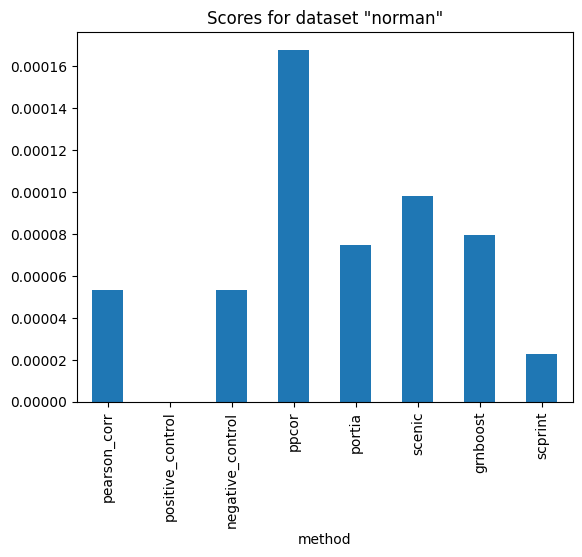

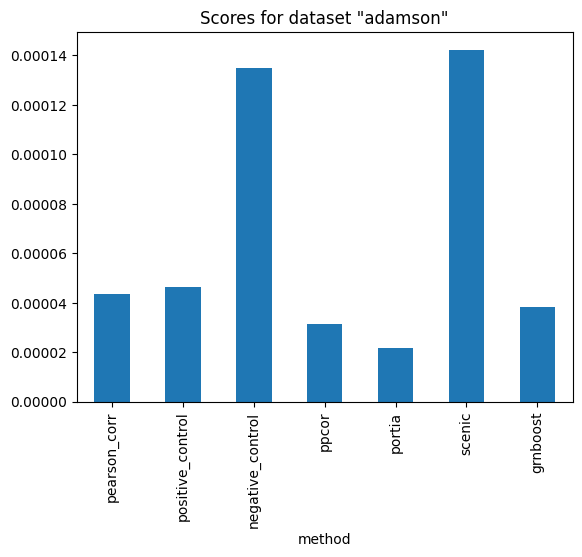

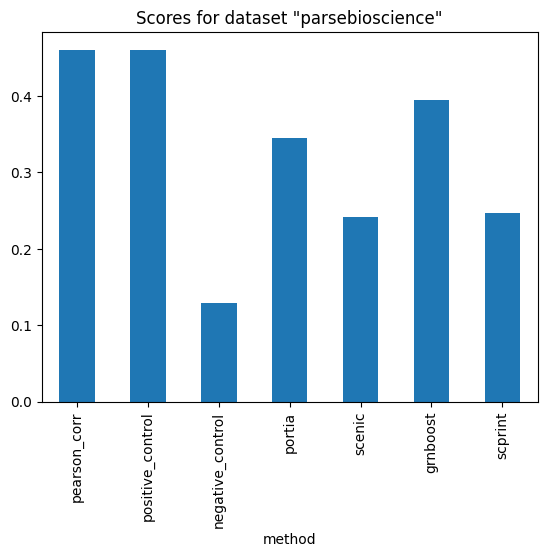

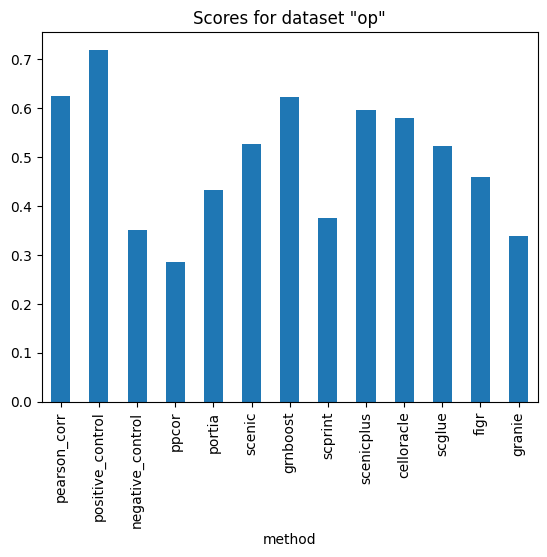

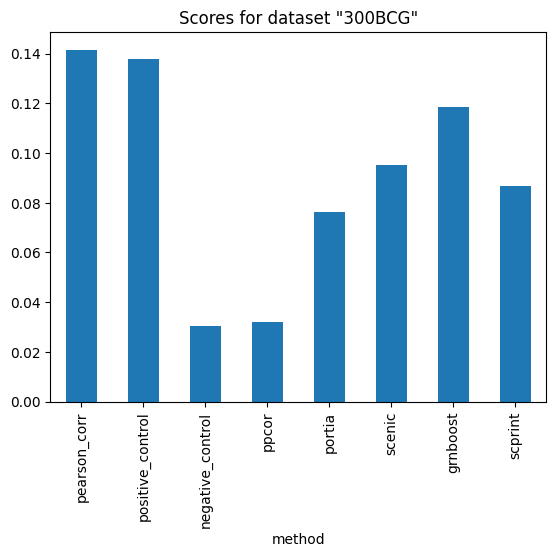

In [4]:
for dataset in df['dataset'].unique():
    df[df['dataset']==dataset].set_index('method')['value'].plot(kind='bar', title=f'Scores for dataset "{dataset}"')
    plt.show()

# Read results of metrics sem

In [ ]:
import os
import scanpy as sc
import pandas as pd
import numpy as np

rr_all = []

for dataset in ['300BCG', 'op', 'parsebioscience']:
    for method in (
        "negative_control", "pearson_corr", "positive_control", "ppcor", "portia",
        "scenic", "grnboost", "scprint", "scenicplus", "celloracle",
        "scglue", "figr", "granie"
    ):
        file_name = f'output/sem/sem_{dataset}_{method}.h5ad'
        if os.path.exists(file_name):
            adata = sc.read_h5ad(file_name)
            ids = adata.uns['metric_ids']
            values = np.array(adata.uns['metric_values'])  # ensure numpy
            
            rr_all.append({
                'method': method,
                'dataset': dataset,
                'value': values[0],
                'ids': ids[0]
            })

# Concatenate results
rr_all = pd.DataFrame(rr_all)

print(rr_all.head())
rr_all[rr_all['dataset']=='parsebioscience'].sort_values('value', ascending=False)

# Overlap of genes in inference and evaluation datasets

In [ ]:
for dataset in ['op', 'nakatake', 'norman', 'adamson', 'xaira_HCT116', 'xaira_HEK293T']:
    adata_inference = ad.read_h5ad(f'resources/grn_benchmark/inference_data/{dataset}_rna.h5ad', backed='r')
    adata_evaluation = ad.read_h5ad(f'resources/grn_benchmark/evaluation_data/{dataset}_bulk.h5ad', backed='r')

    inference_genes = adata_inference.var_names
    evaluation_genes = adata_evaluation.var_names

    common_genes = set(adata_inference.var_names).intersection(set(adata_evaluation.var_names))
    union_genes = set(adata_inference.var_names).union(set(adata_evaluation.var_names))
    only_evaluation = set(adata_evaluation.var_names) - set(adata_inference.var_names)

    print(f'{dataset}:', 
            f'Inference genes: {len(inference_genes)}',
            f'Evaluation genes: {len(evaluation_genes)}',
          f'Common genes: {len(common_genes)}',
          f'Union genes: {len(union_genes)}',
          f'Only evaluation genes: {len(only_evaluation)}')

op: Inference genes: 13595 Evaluation genes: 13595 Common genes: 13595 Union genes: 13595 Only evaluation genes: 0
nakatake: Inference genes: 25090 Evaluation genes: 25090 Common genes: 25090 Union genes: 25090 Only evaluation genes: 0
norman: Inference genes: 3459 Evaluation genes: 3511 Common genes: 3372 Union genes: 3598 Only evaluation genes: 139
adamson: Inference genes: 4786 Evaluation genes: 4932 Common genes: 4785 Union genes: 4933 Only evaluation genes: 147


OSError: Unable to synchronously open file (file signature not found)

# UMAP of perturbations

In [ ]:
!ls resources/extended_data/

adamson_bulk.h5ad  nakatake_bulk.h5ad  replogle_train_sc.h5ad
HCT116_bulk.h5ad   norman_bulk.h5ad    xaira_HCT116_bulk.h5ad
HCT116_sc.h5ad	   op_bulk.h5ad        xaira_HCT116_sc.h5ad
HEK293T_bulk.h5ad  replogle_bulk.h5ad  xaira_HEK293T_bulk.h5ad
HEK293T_sc.h5ad    replogle_sc.h5ad    xaira_HEK293T_sc.h5ad


Processing dataset: xaira_HCT116


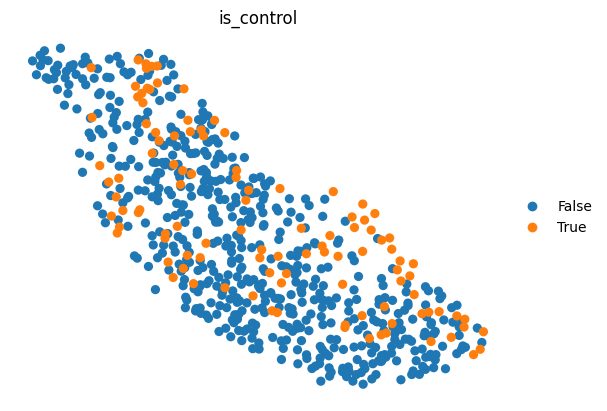

Processing dataset: xaira_HEK293T


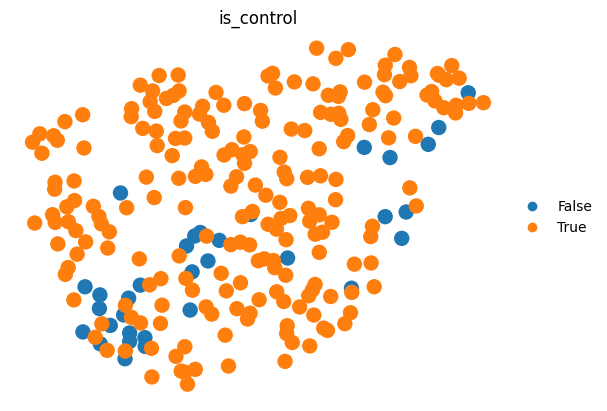

Processing dataset: replogle


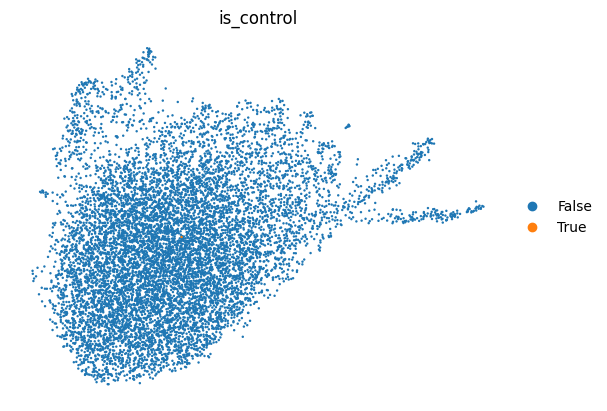

In [ ]:
for dataset in ['xaira_HCT116', 'xaira_HEK293T', 'replogle']:
    print(f'Processing dataset: {dataset}')
    adata = ad.read_h5ad(f'resources/extended_data/{dataset}_bulk.h5ad')

    adata.X = adata.layers['lognorm']
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

    sc.pl.umap(adata,
        color=['is_control'],
        frameon=False,
        wspace=0.5)

# Assemble the results from differnet runs

In [ ]:
!rm -r resources/results/all_main/

In [ ]:
import os
import shutil
import yaml
from pathlib import Path
from collections import OrderedDict

base_dir = 'resources/results/'
save_dir = 'resources/results/all_main/'
runs = ['op', 'nakatake', 'norman', 'replogle', 'adamson']

os.makedirs(save_dir, exist_ok=True)

# 1. Copy one version of the identical files
identical_files = ['method_configs.yaml', 'metric_configs.yaml']
for fname in identical_files:
    src = os.path.join(base_dir, f'{runs[0]}_run', fname)
    dst = os.path.join(save_dir, fname)
    shutil.copyfile(src, dst)
    print(f"Copied identical file: {fname}")

# 2. Merge dataset_uns.yaml by appending all contents
merged_uns = []
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'dataset_uns.yaml')

    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        merged_uns.extend(data)
        
with open(os.path.join(save_dir, 'dataset_uns.yaml'), 'w') as f:
    yaml.dump(merged_uns, f)
print("Merged: dataset_uns.yaml")

# 3. Merge score_uns.yaml similarly
merged_scores = []
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'score_uns.yaml')

    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        # - remove those with missing (because of the metric)
        data = [d for d in data if d is not None and 'missing' not in str(d)]
        
        # print(str(data[0]))
        # aa
        # missing
        if data:
            if isinstance(data, dict):
                merged_scores.append(data)
            elif isinstance(data, list):
                merged_scores.extend(data)
            else:
                print(f"Unexpected format in {path}: {type(data)}")

with open(os.path.join(save_dir, 'score_uns.yaml'), 'w') as f:
    yaml.dump(merged_scores, f)
print("Merged: score_uns.yaml")

# 4. Merge trace.txt with deduplication
seen_lines = OrderedDict()
for run in runs:
    path = os.path.join(base_dir, f'{run}_run', 'trace.txt')
    
    with open(path, 'r') as f:
        for line in f:
            seen_lines[line] = None

with open(os.path.join(save_dir, 'trace.txt'), 'w') as f:
    for line in seen_lines.keys():
        f.write(line)
df = pd.read_csv(os.path.join(save_dir, 'trace.txt'), sep='\t')
df = df.drop_duplicates(subset=['name'])
df.to_csv(os.path.join(save_dir, 'trace.txt'), sep='\t')
print("Merged: trace.txt (duplicates removed)")

# 5. Copy other unknown files/directories
all_known = set(identical_files + ['dataset_uns.yaml', 'score_uns.yaml', 'trace.txt'])

for run in runs:
    run_dir = Path(base_dir) / f'{run}_run'
    for file_path in run_dir.iterdir():
        if file_path.name in all_known:
            continue

        dest_path = Path(save_dir) / file_path.name

        if dest_path.exists():
            dest_path = Path(save_dir) / f"{file_path.stem}_{run}{file_path.suffix}"

        if file_path.is_file():
            shutil.copyfile(file_path, dest_path)
            print(f"Copied unique file: {file_path.name} → {dest_path.name}")
        elif file_path.is_dir():
            shutil.copytree(file_path, dest_path)
            print(f"Copied unique directory: {file_path.name} → {dest_path.name}")

Copied identical file: method_configs.yaml
Copied identical file: metric_configs.yaml
Merged: dataset_uns.yaml
Merged: score_uns.yaml
Merged: trace.txt (duplicates removed)
Copied unique file: state.yaml → state.yaml
Copied unique file: op_.celloracle.celloracle.prediction.h5ad → op_.celloracle.celloracle.prediction.h5ad
Copied unique file: scplus_mdata.h5mu.2DAaAA8E → scplus_mdata.h5mu.2DAaAA8E
Copied unique file: op_.negative_control.negative_control.prediction.h5ad → op_.negative_control.negative_control.prediction.h5ad
Copied unique file: op_.scenicplus.scenicplus.prediction.h5ad → op_.scenicplus.scenicplus.prediction.h5ad
Copied unique file: op_.portia.portia.prediction.h5ad → op_.portia.portia.prediction.h5ad
Copied unique file: op_.granie.granie.prediction.h5ad → op_.granie.granie.prediction.h5ad
Copied unique file: op_.scprint.scprint.prediction.h5ad → op_.scprint.scprint.prediction.h5ad
Copied unique file: op_.pearson_corr.pearson_corr.prediction.h5ad → op_.pearson_corr.pearso

# Rename grnboost2 to grnboost

In [ ]:
import os

target_dir = 'resources/results/all_main'

for root, _, files in os.walk(target_dir):
    for fname in files:
        fpath = os.path.join(root, fname)

        # Skip binary files (optional safety)
        try:
            with open(fpath, 'r', encoding='utf-8') as f:
                content = f.read()
        except UnicodeDecodeError:
            continue  # likely a binary file, skip it

        if 'grnboost2' in content:
            content = content.replace('grnboost2', 'grnboost')
            with open(fpath, 'w', encoding='utf-8') as f:
                f.write(content)
            print(f"Updated: {fpath}")

Updated: resources/results/all_main/trace.txt
Updated: resources/results/all_main/method_configs.yaml
Updated: resources/results/all_main/score_uns.yaml


## Create Nakatake test

In [ ]:
adata = ad.read_h5ad('resources/grn_benchmark/inference_data/nakatake_rna.h5ad')
# Sample 100 cells
sampled_cells = adata.obs.sample(n=100, random_state=0).index

# Sample 2000 genes
sampled_genes = adata.var.sample(n=2000, random_state=0).index

# Subset the AnnData object
adata_subset = adata[sampled_cells, sampled_genes].copy()
adata_subset.write('resources_test/grn_benchmark/inference_data/nakatake_rna.h5ad')

In [ ]:
adata = ad.read_h5ad('resources/grn_benchmark/evaluation_data/nakatake_bulk.h5ad')
# Sample 100 cells
sampled_cells = adata.obs.sample(n=100, random_state=0).index

# Sample 2000 genes
sampled_genes = adata.var.sample(n=2000, random_state=0).index

# Subset the AnnData object
adata_subset = adata[sampled_cells, sampled_genes].copy()
adata_subset.write('resources_test/grn_benchmark/evaluation_data/nakatake_bulk.h5ad')